## Light interception with Caribu

In [1]:
## Imports
import time as t
import math
import numpy as np
from random import *
import matplotlib.pyplot as plt
from scipy.stats import qmc

from oawidgets.plantgl import *
from openalea.plantgl.all import Material, Color3, Scene, Viewer
from alinea.astk import *

from openalea.archicrop.display import build_scene
from openalea.archicrop.simulation import retrieve_stics_dynamics_from_file, dict_ranges_to_all_possible_combinations, generate_single_list_dicts, LHS_param_sampling, params_for_curve_fit
from openalea.archicrop.archicrop import ArchiCrop
from openalea.archicrop.plant_shape import compute_leaf_area_growing_plant, compute_height_growing_plant
from openalea.archicrop.light_it import compute_light_inter
from openalea.archicrop.stand import agronomic_plot

# Enable plotting with PlantGL
%gui qt

# Set nice color for plants
nice_green=Color3((50,100,0))

## Retrieve STICS dynamics from file 

In [2]:
stics_output_file = 'mod_ssorghum.sti'
sowing_density = 10
inter_row = 0.4
stics_output_data = retrieve_stics_dynamics_from_file(stics_output_file, sowing_density)
time = [value["Thermal time"] for value in stics_output_data.values()]
LA_stics = [value["Plant leaf area"] for value in stics_output_data.values()]
height_stics = [value["Plant height"] for value in stics_output_data.values()]
par_stics = [value["Absorbed PAR"] for value in stics_output_data.values()]
height_potential_plant = max(height_stics)

## Vary chosen architectural and developmental parameters and select the sets of parameters that make the model fit

In [3]:
# Define parameter bounds 
# For sorghum
archi_params = dict(
    nb_phy = [10,30], # [10,15,20,25,30], 
    max_leaf_length = [50,120], 
    wl = [0.1,0.12], 
    diam_base = 2.2, 
    diam_top = 1.5, 
    insertion_angle = 30, # to vary for light interception
    scurv = 0.7, # to vary for light interception
    curvature = 90, # to vary for light interception
    alpha = -2.3, 
    stem_q = [1.01,1.2], 
    rmax = [0.6,0.9], # 1-(1/3*(nb_phy - 5)/nb_phy) 
    skew = [0.01, 0.1], # 0.08 # 0.0005 
    phyllotactic_angle = 180, 
    phyllotactic_deviation = 15, # to vary for light interception
    phyllochron = [30,46],
    plastochron = [30,46],
    leaf_duration = [1,6],
    stem_duration = [1,5],
    leaf_senescence = [550, 900]
)

In [4]:
# Function to process parameters and generate samples
# Generate parameter sets
param_sets = LHS_param_sampling(archi_params, n_samples=1000)

In [5]:
# Select parameters sets for which the model fits the LAI and the height curves of the crop model, with a given error.

# Start the timer
start_time = t.time()

fitting_sim = params_for_curve_fit(param_sets, curves=stics_output_data, error_LA=200, error_height=20)

# End the timer
end_time = t.time()

# Calculate elapsed time
elapsed_time = (end_time - start_time)/60
print(f"Elapsed time: {elapsed_time:.4f} minutes")


Elapsed time: 43.0187 minutes


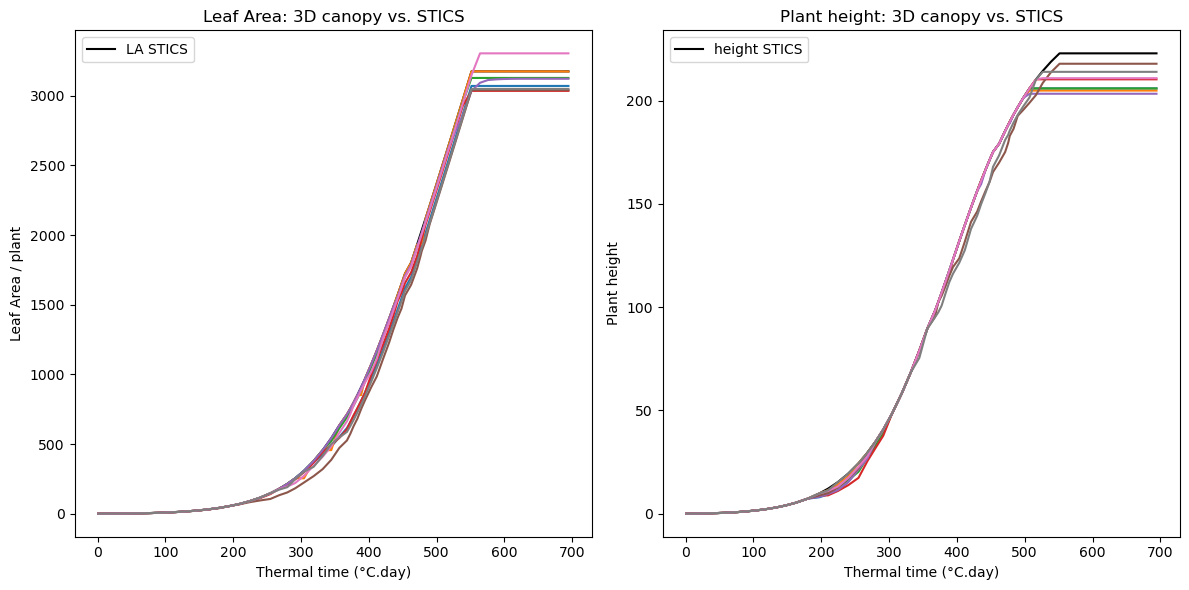

In [6]:
# Create a figure with two subplots side by side
fig, axes = plt.subplots(1, 2, figsize=(12, 6))  # 1 row, 2 columns

# Plot on the first subplot
axes[0].plot(time, LA_stics, color="black", label="LA STICS")
for result in fitting_sim['LA']:
    axes[0].plot(time, result)
axes[0].set_xlabel("Thermal time (°C.day)")
axes[0].set_ylabel("Leaf Area / plant")
axes[0].set_title("Leaf Area: 3D canopy vs. STICS")
axes[0].legend()

# Plot on the second subplot
axes[1].plot(time, height_stics, color="black", label="height STICS")
for result in fitting_sim['height']:
    axes[1].plot(time, result)
axes[1].set_xlabel("Thermal time (°C.day)")
axes[1].set_ylabel("Plant height")
axes[1].set_title("Plant height: 3D canopy vs. STICS")
axes[1].legend()

# Adjust layout
plt.tight_layout()

# Show the plot
plt.show()

In [7]:
good_params = fitting_sim['params']
good_params

[{'diam_base': 2.2,
  'diam_top': 1.5,
  'insertion_angle': 30,
  'scurv': 0.7,
  'curvature': 90,
  'alpha': -2.3,
  'phyllotactic_angle': 180,
  'phyllotactic_deviation': 15,
  'nb_phy': 11,
  'max_leaf_length': 99.38953022234557,
  'wl': 0.10669701997307109,
  'stem_q': 1.1930546737497694,
  'rmax': 0.7975932479443661,
  'skew': 0.07599447227024302,
  'phyllochron': 40.10762088180296,
  'plastochron': 43.734086882182844,
  'leaf_duration': 3.745165180939094,
  'stem_duration': 2.6693719793972353,
  'leaf_senescence': 616.4863456859163},
 {'diam_base': 2.2,
  'diam_top': 1.5,
  'insertion_angle': 30,
  'scurv': 0.7,
  'curvature': 90,
  'alpha': -2.3,
  'phyllotactic_angle': 180,
  'phyllotactic_deviation': 15,
  'nb_phy': 13,
  'max_leaf_length': 118.1105694869254,
  'wl': 0.1093480966460198,
  'stem_q': 1.1497200137218366,
  'rmax': 0.8416458176468843,
  'skew': 0.08228427264284736,
  'phyllochron': 32.493791911914386,
  'plastochron': 43.56492110137314,
  'leaf_duration': 1.201637

In [8]:
# Align `good_params` to `archi_params` order
aligned_good_params = [{key: p[key] for key in archi_params.keys()} for p in good_params]

# Initialize dictionaries for min and max values
min_values = {}
max_values = {}

# Calculate min and max for each parameter
for key in archi_params.keys():
    if isinstance(archi_params[key], list):  # Only for list parameters
        # Extract values for this key across all good_params
        values = [p[key] for p in aligned_good_params]
        min_values[key] = min(values)
        max_values[key] = max(values)

# Update `archi_params` with min and max for list parameters
for key, value in archi_params.items():
    if isinstance(value, list):  # Only update list parameters
        archi_params[key] = [min_values[key], max_values[key]]
        print(f"{key}: {[round(val, 3) for val in archi_params[key]]}")

# Ensure all parameters in `archi_params` are lists
def to_list(d):
    return {k: (v if isinstance(v, list) else [v]) for k, v in d.items()}

archi_params = to_list(archi_params)

# Display updated `archi_params`
print("Updated archi_params:", archi_params)


nb_phy: [10, 15]
max_leaf_length: [88.896, 118.111]
wl: [0.1, 0.116]
stem_q: [1.029, 1.193]
rmax: [0.618, 0.867]
skew: [0.023, 0.09]
phyllochron: [32.494, 44.453]
plastochron: [34.214, 44.456]
leaf_duration: [1.202, 5.48]
stem_duration: [2.53, 4.004]
leaf_senescence: [564.373, 871.884]
Updated archi_params: {'nb_phy': [10, 15], 'max_leaf_length': [88.89606058255535, 118.1105694869254], 'wl': [0.10031167052371445, 0.11604108071175104], 'diam_base': [2.2], 'diam_top': [1.5], 'insertion_angle': [30], 'scurv': [0.7], 'curvature': [90], 'alpha': [-2.3], 'stem_q': [1.0289385173595034, 1.1930546737497694], 'rmax': [0.6177958466512076, 0.8666496205283223], 'skew': [0.02256555190068299, 0.08984296774162541], 'phyllotactic_angle': [180], 'phyllotactic_deviation': [15], 'phyllochron': [32.493791911914386, 44.45272651404066], 'plastochron': [34.21382895687567, 44.45599073202125], 'leaf_duration': [1.2016372244702727, 5.4802652177158215], 'stem_duration': [2.5302271765651745, 4.004192887644081], 'l

In [9]:

################# in function ##################

# Visualize the plants with these parameters

from ipywidgets import interact, interactive, IntSlider, FloatSlider, fixed, Play, HBox, VBox, jslink

# Fix a seed
seed(100)
nice_green = Color3((50, 100, 0))

# slider on parameters with ranges, others fixed 

height=height_potential_plant
nb_phy_slider=IntSlider(min=min(archi_params["nb_phy"]), max=max(archi_params["nb_phy"]), step=1, value=15, description="Nb of phytomers")
max_leaf_length_slider=IntSlider(min=min(archi_params["max_leaf_length"]), max=max(archi_params["max_leaf_length"]), step=1, value=50, description="Length of longest leaf")
wl_slider=FloatSlider(min=min(archi_params["wl"]), max=max(archi_params["wl"]), step=0.01, value=0.12)
diam_base_slider=fixed(archi_params["diam_base"][0])
diam_top_slider=fixed(archi_params["diam_top"][0])
insertion_angle_slider=IntSlider(min=min(archi_params["insertion_angle"]), max=max(archi_params["insertion_angle"]), step=1, value=30)
scurv_slider=FloatSlider(min=min(archi_params["scurv"]), max=max(archi_params["scurv"]), step=0.01, value=0.7)
curvature_slider=IntSlider(min=min(archi_params["curvature"]), max=max(archi_params["curvature"]), step=5, value=90)
alpha_slider=fixed(archi_params["alpha"][0])
stem_q_slider=fixed(archi_params["stem_q"][0])
rmax_slider=FloatSlider(min=min(archi_params["rmax"]), max=max(archi_params["rmax"]), step=0.01, value=0.8)
skew_slider=fixed(archi_params["skew"][0])
phyllotactic_angle_slider=fixed(archi_params["phyllotactic_angle"][0])
phyllotactic_deviation_slider=IntSlider(min=min(archi_params["phyllotactic_deviation"]), max=max(archi_params["phyllotactic_deviation"]), step=5, value=15)
phyllochron_slider=IntSlider(min=min(archi_params["phyllochron"]), max=max(archi_params["phyllochron"]), step=1, value=55)
plastochron_slider=IntSlider(min=min(archi_params["plastochron"]), max=max(archi_params["plastochron"]), step=1, value=40)
leaf_duration_slider=FloatSlider(min=min(archi_params["leaf_duration"]), max=max(archi_params["leaf_duration"]), step=0.1, value=3)
stem_duration_slider=FloatSlider(min=min(archi_params["stem_duration"]), max=max(archi_params["stem_duration"]), step=0.1, value=2)
leaf_senescence_slider=IntSlider(min=min(archi_params["leaf_senescence"]), max=max(archi_params["leaf_senescence"]), step=10, value=800)

time_slider = IntSlider(value=0, min=0, max=len(time), step=1, description="Time")

# Interactive widget setup
play_widget = Play(value=0, min=0, max=len(time), step=1, interval=1000)

# Link play widget with time slider
jslink((play_widget, 'value'), (time_slider, 'value'))

# Callback to update scene
def update_scene(*args):
    seed(100)
    sorghum = ArchiCrop(height, nb_phy_slider.value, max_leaf_length_slider.value, wl_slider.value, 
                        diam_base_slider.value, diam_top_slider.value, insertion_angle_slider.value, scurv_slider.value, 
                        curvature_slider.value, alpha_slider.value, stem_q_slider.value, rmax_slider.value, skew_slider.value, 
                        phyllotactic_angle_slider.value, phyllotactic_deviation_slider.value, 
                        phyllochron_slider.value, plastochron_slider.value, leaf_duration_slider.value, 
                        stem_duration_slider.value, leaf_senescence_slider.value)
    sorghum.generate_potential_plant()
    sorghum.define_development()
    growing_plant = sorghum.grow_plant(stics_output_data)
    growing_plant_mtg = list(growing_plant.values())
    Viewer.display(build_scene(growing_plant_mtg[time_slider.value], leaf_material = Material(nice_green), stem_material=Material(nice_green))[0])

# Attach update callback
nb_phy_slider.observe(update_scene, names='value')
max_leaf_length_slider.observe(update_scene, names='value')
# insertion_angle_slider.observe(update_scene, names='value')
# scurv_slider.observe(update_scene, names='value')
# curvature_slider.observe(update_scene, names='value')
time_slider.observe(update_scene, names='value')

# Display widgets
controls = VBox([nb_phy_slider, max_leaf_length_slider, insertion_angle_slider, scurv_slider, curvature_slider, HBox([time_slider, play_widget])])
display(controls)

# Initial scene display
update_scene()

# cf github openalea weberpenn trunk_parameters

In [10]:
# # Calculate covariance matrix
# covariance_matrix = np.cov(parameters, rowvar=False)

# # Calculate correlation matrix
# correlation_matrix = np.corrcoef(parameters, rowvar=False)

# # Display results
# print("Covariance matrix:\n", covariance_matrix)
# print("Correlation matrix:\n", correlation_matrix)

In [11]:
# from sklearn.decomposition import PCA

# # Perform PCA
# pca = PCA()
# pca.fit(parameters)

# # Principal components and explained variance
# print("Principal components:\n", pca.components_)
# print("Explained variance ratio:", pca.explained_variance_ratio_)

In [12]:
# from sklearn.cluster import KMeans

# # Perform clustering
# num_clusters = 2  # Adjust as needed
# kmeans = KMeans(n_clusters=num_clusters, random_state=42)
# clusters = kmeans.fit_predict(parameters)

# # Add cluster labels to parameter sets
# print("Cluster labels:", clusters)

In [13]:
# import pandas as pd
# import seaborn as sns

# # Heatmap of correlation matrix
# plt.figure(figsize=(10, 8))
# sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm", fmt=".2f")
# plt.title("Parameter Correlation Matrix")
# plt.show()

## Within this space of possible plant architectures regarding parameters affecting plant leaf area and height throught time, we vary parameters related to the orientation of the leaves in space and to crop spatial configuration.

In [14]:
params_to_vary_for_light_it = dict(
    insertion_angle = [10,50],
    scurv = [0.4,0.9],
    curvature = [35,130],
    phyllotactic_deviation = [0,45]
)

crop_params = dict(
    length_plot = 1, 
    width_plot = 1, 
    sowing_density = sowing_density, # [10, 28], 
    inter_row = [0.4, 0.8], # 0.4 for 10
)

In [15]:
# TO DO : vary parameters one by one, then together

## Stand

In [16]:
sorghum = ArchiCrop(height, **good_params[0])
                    # nb_phy, max_leaf_length, wl, 
                    # diam_base, diam_top, insertion_angle, scurv, 
                    # curvature, alpha, stem_q, rmax, skew, 
                    # phyllotactic_angle, phyllotactic_deviation, 
                    # phyllochron, plastochron, leaf_duration, 
                    # stem_duration, leaf_senescence)
sorghum.generate_potential_plant()
scene = sorghum.display_stand(sowing_density=sowing_density, length_plot=1, width_plot=1, inter_row=0.4)

PlantGL(scene)

Plot(antialias=3, axes=['x', 'y', 'z'], axes_helper=1.0, axes_helper_colors=[16711680, 65280, 255], background…

In [17]:
# Store scenes for MTG at all times

sorghum.define_development()
growing_plant = sorghum.grow_plant(stics_output_data)

nplants, positions, domain, domain_area, unit = agronomic_plot(length=1, width=1, sowing_density=10, inter_row=0.4, noise=0.1)

scenes = {}

for k,v in growing_plant.items():
    scene, nump = build_scene([v]*nplants, positions, leaf_material=Material(nice_green), stem_material=Material(nice_green))
    scenes[k] = scene
    

## Compute PAR intercepted

In [18]:
nplants, positions, domain, domain_area, unit = agronomic_plot(length=1, width=1, sowing_density=10, inter_row=0.4, noise=0.1)

par_caribu = []

scenes = []

# Start the timer
start_time = t.time()

for params in good_params:
    sorghum = ArchiCrop(height, **params)
    sorghum.generate_potential_plant()
    sorghum.define_development()
    growing_plant = sorghum.grow_plant(stics_output_data)

    scenes_temp = {}
    for k,v in growing_plant.items():
        scene, nump = build_scene([v]*nplants, positions, leaf_material=Material(nice_green), stem_material=Material(nice_green))
        scenes_temp[k] = scene
    scenes.append(scenes_temp)
    
    par_caribu_temp = []
    for scene in scenes_temp.values():
        par_caribu_temp.append(compute_light_inter(scene))
    par_caribu.append(par_caribu_temp)

# End the timer
end_time = t.time()

# Calculate elapsed time
elapsed_time = (end_time - start_time)/60
print(f"Elapsed time: {elapsed_time:.4f} minutes")

Elapsed time: 20.7545 minutes


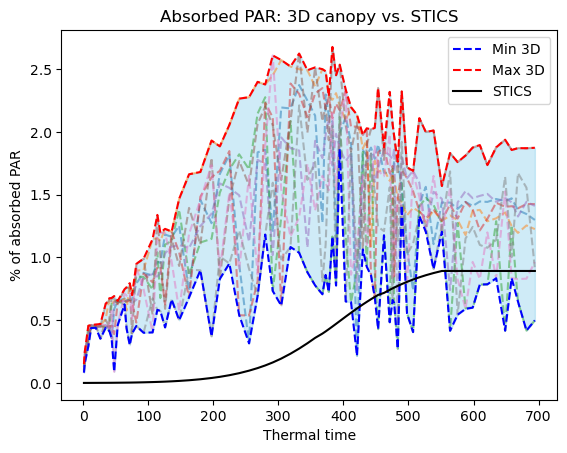

In [19]:
# Convert to a NumPy array for easier manipulation
for i,par in enumerate(par_caribu):
    for j,p in enumerate(par):
        par_caribu[i][j] /= 10
curves = par_caribu
curves_array = np.array(curves)

# Calculate the envelope: min and max values for each time point
min_values = curves_array.min(axis=0)
max_values = curves_array.max(axis=0)

# Plotting the envelope along with individual curves for context
time_points = time
for curve in curves:
    plt.plot(time_points, curve, alpha=0.5, linestyle='--')  # Plot each curve (optional for visualization)

plt.fill_between(time_points, min_values, max_values, color="skyblue", alpha=0.4)
plt.plot(time_points, min_values, color="blue", linestyle="--", label="Min 3D")
plt.plot(time_points, max_values, color="red", linestyle="--", label="Max 3D")
plt.plot(time_points, par_stics, color="black", label="STICS")
# plt.scatter(time_points, LA_stics)

# Labels and legend
plt.xlabel("Thermal time")
plt.ylabel("% of absorbed PAR")
plt.title("Absorbed PAR: 3D canopy vs. STICS")
plt.legend()
plt.show()

## Compute Beer-Lambert light extinction coefficient at each time step

### Light interception in STICS

The radiation intercepted by the crop $raint$ is expressed according to a Beer’s law function of $lai$. The $extinP$ parameter is a daily extinction coefficient and $parsurrgG$ is a climatic parameter corresponding to the ratio (in radiative energy) of photosynthetically active radiation to the global radiation $trg(t)$ (around 0.48, Varlet-Grancher et al. (1982)). 

$$raint(t)=0.95*parsurrgG*trg(t)*(1−exp^{−extinP*(lai(t)+eai(t))})$$

$$extinP = - \frac{1}{lai(t)+eai(t)} ln(1 - \frac{raint(t)}{0.95*parsurrgG*trg(t)})$$

$$extinP = - \frac{1}{lai(t)+eai(t)} ln(1 - ratio\_par\_abs)$$

extin_stics = 0.7

In [20]:
# Compute coef extinP

extinP_list = []

for par_time_series in par_caribu:
    extinP_per_sim = []
    for i,par in enumerate(par_time_series):
        if par < 1:
            lai = LAI_stics[i]*sowing_density/10000 
            extinP = -1/lai * math.log(1-par)
        else:
            extinP = 1
        extinP_per_sim.append(extinP)
    extinP_list.append(extinP_per_sim)

time_points = time[1:]
for curve in extinP_list:
    plt.plot(time_points, curve, alpha=0.5, linestyle='-')
plt.show()

NameError: name 'LAI_stics' is not defined

In [ ]:
# courbe parameters beer-lambert --> analysis of decomposition of uncertainty, parametric

## Next steps

- Simulations to run with IFB Cloud